<a href="https://colab.research.google.com/github/mattiazingaretti/rewts_quant_trading/blob/master/notebooks/train_rewts_deepseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReWTSE-LLM-RL Training Pipeline (DeepSeek)

**Google Colab notebook using DeepSeek-V3.2 for LLM agents**

This notebook provides a complete end-to-end pipeline:
- ✅ Data downloading and preprocessing
- ✅ LLM strategy generation with **DeepSeek** (caching and rate limiting)
- ✅ RL agent training (DDQN ensemble)
- ✅ Backtesting and evaluation
- ✅ Results visualization

**System Architecture:**
- **LLM Agent** (DeepSeek-V3.2): Strategic trading signals
- **RL Agent** (DDQN): Tactical execution policies
- **ReWTSE Ensemble**: Weighted ensemble with QP optimization

**No Google Cloud Required!**
- All training runs directly on Google Colab
- DeepSeek API via OpenAI-compatible interface

**Costs:**
- Training 6 tickers: ~$0.21 (with 50% cache)
- Annual (12x): ~$2.51/year

## 1. Environment Setup

In [1]:
# Detect environment (Colab or Local)
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Running on Google Colab")
except:
    IN_COLAB = False
    print("💻 Running locally")

# Check GPU availability
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

🚀 Running on Google Colab

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA L4
CUDA version: 12.6


In [2]:
# Mount Google Drive (only on Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted!")
else:
    print("Skipping Google Drive mount (not on Colab)")

Mounted at /content/drive
✓ Google Drive mounted!


In [3]:
import os

# Setup project path
if IN_COLAB:
    print("Google Colab Setup:\n")
    print("Option 1: Clone from GitHub (Recommended)")
    !git clone https://github.com/mattiazingaretti/rewts_quant_trading.git
    %cd rewts_quant_trading

    # Alternative: use from Google Drive
    # Uncomment and modify the path to your project folder:
    # project_path = '/content/drive/MyDrive/rewts_quant_trading'
    # os.chdir(project_path)
else:
    print("Local Setup:")
    # Navigate to project root if needed
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')
        print("Changed to project root directory")

print(f"\nCurrent working directory: {os.getcwd()}")

Google Colab Setup:

Option 1: Clone from GitHub (Recommended)
Cloning into 'rewts_quant_trading'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 244 (delta 81), reused 221 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (244/244), 2.22 MiB | 47.46 MiB/s, done.
Resolving deltas: 100% (81/81), done.
/content/rewts_quant_trading

Current working directory: /content/rewts_quant_trading


In [4]:
# Install required packages
print("Installing dependencies...\n")

if IN_COLAB:
    !pip install -q -r requirements.txt
    print("\n✓ Dependencies installed!")
else:
    print("Local environment detected.")
    print("Make sure dependencies are installed: pip install -r requirements.txt")

Installing dependencies...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 140.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 150.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 7.1.0 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2

## 2. Configuration

In [5]:
# API Configuration
import os
from getpass import getpass

# Set your DeepSeek API key
# Get your API key from: https://platform.deepseek.com

DEEPSEEK_API_KEY = None

# Method 1: Google Colab Secrets (recommended on Colab)
if IN_COLAB:
    try:
        from google.colab import userdata
        DEEPSEEK_API_KEY = userdata.get('DEEPSEEK_API_KEY')
        print("✓ Using DEEPSEEK_API_KEY from Colab Secrets")
    except Exception as e:
        print(f"ℹ️  Colab Secrets not configured: {e}")
        print("   You can add secrets at: Runtime → Manage secrets → Add secret")
        print("   Name: DEEPSEEK_API_KEY, Value: sk-...")

# Method 2: Environment variables
if DEEPSEEK_API_KEY is None and os.getenv('DEEPSEEK_API_KEY'):
    DEEPSEEK_API_KEY = os.getenv('DEEPSEEK_API_KEY')
    print("✓ Using DEEPSEEK_API_KEY from environment variables")

# Method 3: Manual input (fallback)
if DEEPSEEK_API_KEY is None:
    print("\nEnter your DeepSeek API Key (input will be hidden)")
    DEEPSEEK_API_KEY = getpass('DeepSeek API Key: ')
    print("✓ API key entered manually")

# Set environment variable
os.environ['DEEPSEEK_API_KEY'] = DEEPSEEK_API_KEY

print("\n✓ API key configured!")
print("\n💰 Estimated cost: ~$0.21 for 6 tickers (with cache)")
print("\n📚 How to add Colab Secrets:")
print("  1. Click on 🔑 icon in left sidebar (Secrets)")
print("  2. Click '+ Add new secret'")
print("  3. Name: DEEPSEEK_API_KEY")
print("  4. Value: sk-... (your API key)")
print("  5. Enable 'Notebook access'")
print("  6. Restart runtime and re-run cells")

✓ Using DEEPSEEK_API_KEY from Colab Secrets

✓ API key configured!

💰 Estimated cost: ~$0.21 for 6 tickers (with cache)

📚 How to add Colab Secrets:
  1. Click on 🔑 icon in left sidebar (Secrets)
  2. Click '+ Add new secret'
  3. Name: DEEPSEEK_API_KEY
  4. Value: sk-... (your API key)
  5. Enable 'Notebook access'
  6. Restart runtime and re-run cells


In [6]:
# Training Configuration
config = {
    # Tickers to train (you can add more)
    'tickers': ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA'],

    # Data configuration
    'start_date': '2012-01-01',
    'end_date': '2020-12-31',

    # LLM Configuration (DeepSeek)
    'llm': {
        'llm_model': 'deepseek-chat',  # DeepSeek-V3.2
        'temperature': 0.0,
        'deepseek_api_key': os.getenv('DEEPSEEK_API_KEY'),
    },

    # ReWTSE Configuration (Optimized)
    'rewts': {
        'chunk_length': 400,
        'lookback_length': 200,
        'forecast_horizon': 1,
        'episodes_per_chunk': 100,

        # DDQN Hyperparameters
        'gamma': 0.995,
        'epsilon_start': 1.0,
        'epsilon_min': 0.05,
        'epsilon_decay': 0.998,
        'learning_rate': 5e-4,
        'batch_size': 128,
        'buffer_size': 50000,
        'target_update_freq': 20,
        'hidden_dims': [256, 256, 128]
    },

    # Trading Environment
    'trading_env': {
        'initial_balance': 10000,
        'transaction_cost': 0.0015,
        'max_position': 0.95,
        'max_drawdown_limit': 0.15
    },

    # Strategy generation frequency (days)
    'strategy_frequency': 20,

    # Performance optimization
    'parallel_workers': 8,  # Parallel LLM strategy generation
    'max_requests_per_second': 8.0,  # Rate limiting for API
    'skip_news_processing': False  # Skip news to save 50% API calls
}

import json
print("Configuration (DeepSeek):")
print("="*70)
print(json.dumps({k: v for k, v in config.items() if k != 'llm'}, indent=2))
print(f"\nLLM Model: {config['llm']['llm_model']}")
print(f"Tickers: {config['tickers']}")
print(f"\n⚠️ News processing: {'DISABLED' if config.get('skip_news_processing') else 'ENABLED'}")
if config.get('skip_news_processing'):
    print("   (This saves 50% of API calls by using neutral sentiment)")
print("="*70)

Configuration (DeepSeek):
{
  "tickers": [
    "AAPL",
    "GOOGL",
    "MSFT",
    "AMZN",
    "META",
    "TSLA"
  ],
  "start_date": "2012-01-01",
  "end_date": "2020-12-31",
  "rewts": {
    "chunk_length": 400,
    "lookback_length": 200,
    "forecast_horizon": 1,
    "episodes_per_chunk": 100,
    "gamma": 0.995,
    "epsilon_start": 1.0,
    "epsilon_min": 0.05,
    "epsilon_decay": 0.998,
    "learning_rate": 0.0005,
    "batch_size": 128,
    "buffer_size": 50000,
    "target_update_freq": 20,
    "hidden_dims": [
      256,
      256,
      128
    ]
  },
  "trading_env": {
    "initial_balance": 10000,
    "transaction_cost": 0.0015,
    "max_position": 0.95,
    "max_drawdown_limit": 0.15
  },
  "strategy_frequency": 20,
  "parallel_workers": 8,
  "max_requests_per_second": 8.0,
  "skip_news_processing": false
}

LLM Model: deepseek-chat
Tickers: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA']

⚠️ News processing: ENABLED


## 3. Import Modules

In [7]:
# Add project to path
import sys
import os

project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules (DeepSeek versions)
from scripts.training.download_data import DataDownloader
from src.llm_agents.strategist_agent_deepseek import StrategistAgent, TradingStrategy
from src.llm_agents.analyst_agent_deepseek import AnalystAgent
from src.rl_agents.trading_env import TradingEnv
from src.hybrid_model.ensemble_controller import ReWTSEnsembleController
from src.utils.data_utils import load_market_data, load_news_data, filter_news_by_period
from src.utils.strategy_cache import StrategyCache
from src.utils.rate_limiter import RateLimiter, RequestMonitor, retry_with_exponential_backoff

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

print("✓ Modules imported successfully!")
print("✓ Using DeepSeek agents")

✓ Modules imported successfully!
✓ Using DeepSeek agents


## 4. Data Download

Download and prepare market data for all tickers.

In [8]:
# Check if data already exists
data_missing = False
for ticker in config['tickers']:
    market_path = f"data/processed/{ticker}_full_data.csv"
    news_path = f"data/processed/{ticker}_news.csv"

    if not os.path.exists(market_path) or not os.path.exists(news_path):
        data_missing = True
        break

if data_missing:
    print("\n" + "="*60)
    print("Downloading market data...")
    print("="*60)

    downloader = DataDownloader(config)
    datasets = downloader.prepare_full_dataset()

    print("\n" + "="*60)
    print("✓ Data download complete!")
    print("="*60)
else:
    print("\n" + "="*60)
    print("✓ All data already exists")
    print("="*60)

# Verify data
print("\nData verification:")
for ticker in config['tickers']:
    market_path = f"data/processed/{ticker}_full_data.csv"
    if os.path.exists(market_path):
        df = pd.read_csv(market_path, index_col=0)
        print(f"  {ticker}: ✓ ({len(df)} days)")
    else:
        print(f"  {ticker}: ✗ NOT FOUND")



Processing AAPL...
Computing technical indicators...
Creating mock news data for AAPL...
✓ Saved AAPL data (2215 records)

Processing GOOGL...
Computing technical indicators...
Creating mock news data for GOOGL...
✓ Saved GOOGL data (2215 records)

Processing MSFT...
Computing technical indicators...
Creating mock news data for MSFT...
✓ Saved MSFT data (2215 records)

Processing AMZN...
Computing technical indicators...
Creating mock news data for AMZN...
✓ Saved AMZN data (2215 records)

Processing META...
Computing technical indicators...
Creating mock news data for META...
✓ Saved META data (2120 records)

Processing TSLA...
Computing technical indicators...
Creating mock news data for TSLA...
✓ Saved TSLA data (2215 records)

✓ Data download complete!

Data verification:
  AAPL: ✓ (2215 days)
  GOOGL: ✓ (2215 days)
  MSFT: ✓ (2215 days)
  AMZN: ✓ (2215 days)
  META: ✓ (2120 days)
  TSLA: ✓ (2215 days)


## 5. LLM Strategy Generation

Generate trading strategies using Gemini LLM with:
- **Smart caching**: Avoid duplicate API calls
- **Rate limiting**: Respect API quotas
- **Parallel execution**: Generate multiple strategies concurrently
- **Automatic retry**: Handle rate limit errors gracefully

In [ ]:
def precompute_llm_strategies(ticker, market_df, news_df, config):
    """Generate LLM strategies with caching, rate limiting, and parallelization"""

    print(f"\n{'='*60}")
    print(f"Generating LLM Strategies for {ticker}")
    print(f"{'='*60}")

    # Initialize cache and rate limiter
    cache = StrategyCache()
    max_workers = config.get('parallel_workers', 8)
    max_rps = config.get('max_requests_per_second', 8.0)
    skip_news = config.get('skip_news_processing', False)

    rate_limiter = RateLimiter(max_per_second=max_rps)
    monitor = RequestMonitor(window_seconds=60, limit_rpm=1000)

    strategist = StrategistAgent(config['llm'])
    analyst = AnalystAgent(config['llm']) if not skip_news else None

    print(f"Parallel workers: {max_workers}")
    print(f"Rate limit: {max_rps} req/s")
    if skip_news:
        print("⚠️  News processing DISABLED (saves 50% API calls)")

    # Prepare tasks
    strategy_frequency = config['strategy_frequency']
    num_strategies = len(market_df) // strategy_frequency

    task_params = []
    for i in range(num_strategies):
        start_idx = i * strategy_frequency
        end_idx = min((i + 1) * strategy_frequency, len(market_df))
        period_data = market_df.iloc[start_idx:end_idx]
        period_news = filter_news_by_period(news_df, period_data.index[0], period_data.index[-1])

        # Prepare input data
        market_data = {
            'timestamp': str(period_data.index[-1]),
            'Close': float(period_data['Close'].iloc[-1]),
            'Volume': float(period_data['Volume'].iloc[-1]),
            'Weekly_Returns': period_data['Close'].pct_change().tail(20).tolist(),
            'HV_Close': float(period_data.get('HV_Close', pd.Series([0])).iloc[-1]),
            'Beta': 1.0,
            'Classification': 'Growth'
        }

        fundamentals = {
            'current_ratio': float(period_data.get('Current_Ratio', pd.Series([1.5])).iloc[-1]),
            'debt_to_equity': float(period_data.get('Debt_to_Equity', pd.Series([0.5])).iloc[-1]),
            'pe_ratio': float(period_data.get('PE_Ratio', pd.Series([20])).iloc[-1]),
            'gross_margin': float(period_data.get('Gross_Margin', pd.Series([0.4])).iloc[-1]),
            'operating_margin': float(period_data.get('Operating_Margin', pd.Series([0.2])).iloc[-1]),
            'eps_yoy': 0.1,
            'net_income_yoy': 0.1
        }

        analytics = {
            'ma_20': float(period_data['SMA_20'].iloc[-1]),
            'ma_50': float(period_data['SMA_50'].iloc[-1]),
            'ma_200': float(period_data['SMA_200'].iloc[-1]),
            'ma_20_slope': float(period_data['SMA_20_Slope'].iloc[-1]),
            'ma_50_slope': float(period_data['SMA_50_Slope'].iloc[-1]),
            'rsi': float(period_data['RSI'].iloc[-1]),
            'macd': float(period_data['MACD'].iloc[-1]),
            'macd_signal': float(period_data['MACD_Signal'].iloc[-1]),
            'atr': float(period_data['ATR'].iloc[-1])
        }

        macro_data = {
            'SPX_Close': float(period_data.get('SPX_Close', pd.Series([0])).iloc[-1]),
            'VIX_Close': float(period_data.get('VIX_Close', pd.Series([0])).iloc[-1]),
            'GDP_QoQ': 0.0,
            'PMI': 50.0
        }

        task_params.append({
            'task_id': i,
            'period_news': period_news,
            'market_data': market_data,
            'fundamentals': fundamentals,
            'analytics': analytics,
            'macro_data': macro_data
        })

    print(f"\nPrepared {len(task_params)} strategy generation tasks")

    # Worker function
    def generate_single_strategy(params):
        task_id = params['task_id']

        # Process news
        if skip_news or len(params['period_news']) == 0 or analyst is None:
            news_signals = {'sentiment': 'neutral', 'confidence': 0.5, 'key_topics': []}
        else:
            news_signals = analyst.process_news(params['period_news'].to_dict('records'))

        # Check cache
        cached = cache.get(
            ticker=ticker,
            market_data=params['market_data'],
            fundamentals=params['fundamentals'],
            analytics=params['analytics'],
            macro_data=params['macro_data'],
            news_signals=news_signals,
            model_name=config['llm']['llm_model'],
            temperature=config['llm']['temperature']
        )

        if cached is not None:
            return {'task_id': task_id, 'strategy': TradingStrategy(**cached), 'from_cache': True}

        # Generate with rate limiting
        rate_limiter.wait()
        monitor.record_request()

        try:
            strategy = retry_with_exponential_backoff(
                lambda: strategist.generate_strategy(
                    market_data=params['market_data'],
                    fundamentals=params['fundamentals'],
                    analytics=params['analytics'],
                    macro_data=params['macro_data'],
                    news_signals=news_signals,
                    last_strategy=None
                ),
                max_retries=3,
                initial_wait=2.0,
                max_wait=30.0
            )

            # Save to cache
            cache.set(
                ticker=ticker,
                market_data=params['market_data'],
                fundamentals=params['fundamentals'],
                analytics=params['analytics'],
                macro_data=params['macro_data'],
                news_signals=news_signals,
                model_name=config['llm']['llm_model'],
                temperature=config['llm']['temperature'],
                strategy=strategy
            )

            return {'task_id': task_id, 'strategy': strategy, 'from_cache': False}

        except Exception as e:
            print(f"\n❌ Failed strategy {task_id}: {e}")
            # Fallback
            return {
                'task_id': task_id,
                'strategy': TradingStrategy(
                    direction=1, confidence=1.5, strength=0.5,
                    explanation=f'Fallback: {str(e)}',
                    features_used=[], timestamp=params['market_data']['timestamp']
                ),
                'from_cache': False, 'error': True
            }

    # Execute in parallel
    print(f"\n🚀 Starting parallel generation...")
    start_time = time.time()

    strategies_dict = {}
    cache_hits = 0

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(generate_single_strategy, p): p['task_id'] for p in task_params}

        for i, future in enumerate(as_completed(futures), 1):
            result = future.result()
            strategies_dict[result['task_id']] = result['strategy']
            if result['from_cache']:
                cache_hits += 1

            if i % 10 == 0:
                elapsed = time.time() - start_time
                rate = i / elapsed
                eta = (len(task_params) - i) / rate if rate > 0 else 0
                print(f"Progress: {i}/{len(task_params)} ({100*i/len(task_params):.1f}%) | "
                      f"Rate: {rate:.1f} strat/s | ETA: {eta:.0f}s")

    # Reorder strategies
    strategies = [strategies_dict[i] for i in range(len(task_params))]

    elapsed = time.time() - start_time
    print(f"\n✓ Generated {len(strategies)} strategies in {elapsed:.1f}s")
    print(f"  Cache hits: {cache_hits} ({100*cache_hits/len(strategies):.1f}%)")
    print(f"  API calls saved: {cache_hits}")

    # Save strategies locally
    os.makedirs('data/llm_strategies', exist_ok=True)
    local_strategy_path = f"data/llm_strategies/{ticker}_strategies.pkl"
    with open(local_strategy_path, 'wb') as f:
        pickle.dump(strategies, f)
    print(f"  ✓ Saved locally: {local_strategy_path}")

    # Save to Google Drive if on Colab (BUGFIX!)
    if IN_COLAB:
        try:
            drive_strategies_path = '/content/drive/MyDrive/rewts_models/strategies'
            os.makedirs(drive_strategies_path, exist_ok=True)
            drive_strategy_file = f"{drive_strategies_path}/{ticker}_strategies.pkl"
            with open(drive_strategy_file, 'wb') as f:
                pickle.dump(strategies, f)
            print(f"  ✓ Also saved to Google Drive: {drive_strategy_file}")
        except Exception as e:
            print(f"  ⚠️ Could not save strategies to Drive: {e}")

    return strategies

## 6. RL Ensemble Training

Train DDQN agents on different time chunks and create a weighted ensemble.

In [10]:
def train_rewts_ensemble(ticker, market_df, strategies, config):
    """Train ReWTSE ensemble of DDQN agents"""

    print(f"\n{'='*60}")
    print(f"Training ReWTSE Ensemble for {ticker}")
    print(f"{'='*60}")

    ensemble = ReWTSEnsembleController(config['rewts'])

    chunk_length = config['rewts']['chunk_length']
    num_chunks = len(market_df) // chunk_length

    print(f"Data points: {len(market_df)}")
    print(f"Chunk length: {chunk_length}")
    print(f"Number of chunks: {num_chunks}")
    print(f"Episodes per chunk: {config['rewts']['episodes_per_chunk']}")

    for chunk_id in range(num_chunks):
        start_idx = chunk_id * chunk_length
        end_idx = min((chunk_id + 1) * chunk_length, len(market_df))

        chunk_df = market_df.iloc[start_idx:end_idx].copy()

        strategy_start = start_idx // config['strategy_frequency']
        strategy_end = end_idx // config['strategy_frequency']
        chunk_strategies = strategies[strategy_start:strategy_end]

        if len(chunk_strategies) == 0:
            print(f"⚠️ No strategies for chunk {chunk_id}, skipping")
            continue

        print(f"\nChunk {chunk_id}: {len(chunk_df)} days, {len(chunk_strategies)} strategies")

        env = TradingEnv(chunk_df, chunk_strategies, config['trading_env'])
        agent = ensemble.train_chunk_model(
            chunk_id=chunk_id,
            env=env,
            num_episodes=config['rewts']['episodes_per_chunk']
        )

        ensemble.chunk_models.append(agent)

    print(f"\n✓ Ensemble training complete! ({len(ensemble.chunk_models)} models)")
    return ensemble

## 7. Complete Training Pipeline

Execute the full training pipeline for all tickers.

In [ ]:
# Track training results
trained_models = {}

print("="*80)
print("MULTI-TICKER TRAINING PIPELINE")
print("="*80)
print(f"Tickers: {config['tickers']}")
print(f"Estimated time: ~20-30 min per ticker")
print("="*80)

# Import garbage collector for memory cleanup
import gc
import shutil

# Setup Drive paths
if IN_COLAB:
    DRIVE_MODELS_PATH = '/content/drive/MyDrive/rewts_models'
    DRIVE_STRATEGIES_PATH = '/content/drive/MyDrive/rewts_models/strategies'
else:
    DRIVE_MODELS_PATH = None
    DRIVE_STRATEGIES_PATH = None

for idx, ticker in enumerate(config['tickers'], 1):
    print(f"\n{'#'*80}")
    print(f"# [{idx}/{len(config['tickers'])}] Processing {ticker}")
    print(f"{'#'*80}")

    # Paths
    local_model_path = f"models/{ticker}_rewts_ensemble.pkl"
    local_strategy_path = f"data/llm_strategies/{ticker}_strategies.pkl"
    drive_model_path = f"{DRIVE_MODELS_PATH}/{ticker}_rewts_ensemble.pkl" if DRIVE_MODELS_PATH else None
    drive_strategy_path = f"{DRIVE_STRATEGIES_PATH}/{ticker}_strategies.pkl" if DRIVE_STRATEGIES_PATH else None

    # Check 1: Local model exists
    if os.path.exists(local_model_path):
        print(f"✓ Model already exists locally: {local_model_path}")
        print(f"  Skipping training for {ticker}")
        print(f"  (Model not loaded to save RAM)")
        continue

    # Check 2: Drive model exists (only on Colab)
    if IN_COLAB and drive_model_path and os.path.exists(drive_model_path):
        print(f"✓ Model already exists on Google Drive: {drive_model_path}")
        print(f"  Skipping training for {ticker}")

        # Copy model from Drive to local (for backtesting)
        try:
            print(f"  📥 Copying model from Drive to local...")
            os.makedirs('models', exist_ok=True)
            shutil.copy2(drive_model_path, local_model_path)
            print(f"  ✓ Model copied to {local_model_path}")
        except Exception as e:
            print(f"  ⚠️ Could not copy model from Drive: {e}")

        # Copy strategies from Drive to local (BUGFIX!)
        if drive_strategy_path and os.path.exists(drive_strategy_path):
            try:
                print(f"  📥 Copying strategies from Drive to local...")
                os.makedirs('data/llm_strategies', exist_ok=True)
                shutil.copy2(drive_strategy_path, local_strategy_path)
                print(f"  ✓ Strategies copied to {local_strategy_path}")
            except Exception as e:
                print(f"  ⚠️ Could not copy strategies from Drive: {e}")
        else:
            print(f"  ⚠️ Strategies not found on Drive: {drive_strategy_path}")

        continue

    # Model doesn't exist anywhere - train it!
    print(f"\n🎯 Model not found (local or Drive) - starting training...")

    try:
        # 1. Load data
        print(f"\n[1/4] Loading data...")
        market_df = load_market_data(ticker)
        news_df = load_news_data(ticker)
        print(f"  ✓ Market: {len(market_df)} days | News: {len(news_df)} articles")

        # 2. Generate strategies
        print(f"\n[2/4] Generating LLM strategies...")
        strategies = precompute_llm_strategies(ticker, market_df, news_df, config)
        print(f"  ✓ Generated {len(strategies)} strategies")

        # Free memory after strategy generation
        del market_df, news_df
        gc.collect()

        # Reload market data for training
        market_df = load_market_data(ticker)

        # 3. Train ensemble
        print(f"\n[3/4] Training ReWTSE ensemble...")
        ensemble = train_rewts_ensemble(ticker, market_df, strategies, config)
        print(f"  ✓ Trained {len(ensemble.chunk_models)} chunk models")

        # Free memory after training
        del market_df, strategies
        gc.collect()

        # 4. Save model
        print(f"\n[4/4] Saving model...")
        os.makedirs('models', exist_ok=True)
        with open(local_model_path, 'wb') as f:
            pickle.dump(ensemble, f)
        print(f"  ✓ Saved to {local_model_path}")

        # Save to Google Drive if on Colab
        if IN_COLAB and DRIVE_MODELS_PATH:
            try:
                os.makedirs(DRIVE_MODELS_PATH, exist_ok=True)
                with open(drive_model_path, 'wb') as f:
                    pickle.dump(ensemble, f)
                print(f"  ✓ Also saved to Google Drive: {drive_model_path}")
            except Exception as e:
                print(f"  ⚠️ Could not save to Drive: {e}")

        # Don't keep in memory - free it!
        print(f"\n💾 Freeing memory...")
        del ensemble
        gc.collect()

        print(f"\n{'='*80}")
        print(f"✅ {ticker} training complete!")
        print(f"{'='*80}")

        # Print memory usage if psutil available
        try:
            import psutil
            process = psutil.Process()
            mem_info = process.memory_info()
            mem_mb = mem_info.rss / 1024 / 1024
            print(f"📊 Current memory usage: {mem_mb:.1f} MB")
        except ImportError:
            pass

    except Exception as e:
        print(f"\n{'='*80}")
        print(f"❌ Error training {ticker}: {e}")
        print(f"{'='*80}")
        import traceback
        traceback.print_exc()

        # Clean up on error
        gc.collect()
        continue

print(f"\n{'='*80}")
print(f"TRAINING COMPLETE")
print(f"{'='*80}")

# Summary of what was done
local_models = [f for f in os.listdir('models') if f.endswith('_rewts_ensemble.pkl')] if os.path.exists('models') else []
local_strategies = [f for f in os.listdir('data/llm_strategies') if f.endswith('_strategies.pkl')] if os.path.exists('data/llm_strategies') else []

print(f"\n📊 Summary:")
print(f"  Local models: {len(local_models)}")
for model in local_models:
    print(f"    - {model}")

print(f"\n  Local strategies: {len(local_strategies)}")
for strategy in local_strategies:
    print(f"    - {strategy}")

if IN_COLAB and DRIVE_MODELS_PATH and os.path.exists(DRIVE_MODELS_PATH):
    drive_models = [f for f in os.listdir(DRIVE_MODELS_PATH) if f.endswith('_rewts_ensemble.pkl')]
    print(f"\n  Drive models: {len(drive_models)}")
    for model in drive_models:
        print(f"    - {model}")

if IN_COLAB and DRIVE_STRATEGIES_PATH and os.path.exists(DRIVE_STRATEGIES_PATH):
    drive_strategies = [f for f in os.listdir(DRIVE_STRATEGIES_PATH) if f.endswith('_strategies.pkl')]
    print(f"\n  Drive strategies: {len(drive_strategies)}")
    for strategy in drive_strategies:
        print(f"    - {strategy}")

print(f"\n{'='*80}")
print(f"\n💡 Note: Models not kept in memory to save RAM")
print(f"   Load them individually for backtesting if needed")

## 8. Backtesting

Evaluate trained models on the full dataset.

In [12]:
def calculate_metrics(portfolio_history, initial_balance=10000):
    """Calculate trading metrics"""
    if len(portfolio_history) == 0:
        return {'total_return': 0.0, 'sharpe_ratio': 0.0, 'max_drawdown': 0.0,
                'volatility': 0.0, 'win_rate': 0.0}

    portfolio_values = np.array(portfolio_history)
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_balance) / initial_balance

    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    returns = returns[np.isfinite(returns)]

    if len(returns) == 0 or np.std(returns) == 0:
        return {'total_return': total_return, 'sharpe_ratio': 0.0,
                'max_drawdown': 0.0, 'volatility': 0.0, 'win_rate': 0.0}

    sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252)
    peak = np.maximum.accumulate(portfolio_values)
    drawdowns = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdowns)
    volatility = np.std(returns) * np.sqrt(252)
    win_rate = (returns > 0).sum() / len(returns)

    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'volatility': volatility,
        'win_rate': win_rate
    }

print("="*80)
print("BACKTESTING")
print("="*80)
print("\n💡 Loading models one at a time to save RAM\n")

results = []

# Import garbage collector
import gc

for ticker in config['tickers']:
    model_path = f"models/{ticker}_rewts_ensemble.pkl"

    if not os.path.exists(model_path):
        print(f"\n⚠️ Model not found for {ticker}")
        continue

    print(f"\n{'='*60}")
    print(f"Evaluating {ticker}")
    print(f"{'='*60}")

    try:
        # Load model
        print(f"Loading model...")
        with open(model_path, 'rb') as f:
            ensemble = pickle.load(f)

        # Load strategies
        with open(f"data/llm_strategies/{ticker}_strategies.pkl", 'rb') as f:
            strategies = pickle.load(f)

        # Load market data
        market_df = load_market_data(ticker)

        # Create environment
        eval_env = TradingEnv(market_df, strategies, config['trading_env'])
        ensemble.current_weights = np.ones(len(ensemble.chunk_models)) / len(ensemble.chunk_models)

        # Run evaluation
        state = eval_env.reset()
        done = False
        actions_taken = []

        while not done:
            action, _ = ensemble.predict_ensemble(state)
            actions_taken.append(action)
            state, reward, done, _ = eval_env.step(action)

        # Calculate metrics
        initial_balance = config['trading_env']['initial_balance']
        final_value = eval_env.portfolio_value
        metrics = calculate_metrics(eval_env.portfolio_history, initial_balance)

        # Print results
        print(f"Initial Balance:  ${initial_balance:,.2f}")
        print(f"Final Value:      ${final_value:,.2f}")
        print(f"Total Return:     {metrics['total_return']:.2%}")
        print(f"Sharpe Ratio:     {metrics['sharpe_ratio']:.2f}")
        print(f"Max Drawdown:     {metrics['max_drawdown']:.2%}")
        print(f"Volatility:       {metrics['volatility']:.2%}")
        print(f"Win Rate:         {metrics['win_rate']:.2%}")

        results.append({
            'ticker': ticker,
            'final_value': final_value,
            'metrics': metrics
        })

        # Free memory after each ticker
        print(f"\nFreeing memory...")
        del ensemble, strategies, market_df, eval_env, actions_taken
        gc.collect()

    except Exception as e:
        print(f"✗ Error: {e}")
        gc.collect()

# Summary
if len(results) > 0:
    print(f"\n{'='*80}")
    print("SUMMARY")
    print(f"{'='*80}")

    print(f"\n{'Ticker':<10} {'Return':<12} {'Sharpe':<10} {'Max DD':<12} {'Volatility':<12}")
    print("-"*60)

    for r in results:
        m = r['metrics']
        print(f"{r['ticker']:<10} {m['total_return']:<12.2%} {m['sharpe_ratio']:<10.2f} "
              f"{m['max_drawdown']:<12.2%} {m['volatility']:<12.2%}")

    # Averages
    avg_return = np.mean([r['metrics']['total_return'] for r in results])
    avg_sharpe = np.mean([r['metrics']['sharpe_ratio'] for r in results])
    avg_dd = np.mean([r['metrics']['max_drawdown'] for r in results])
    avg_vol = np.mean([r['metrics']['volatility'] for r in results])

    print("-"*60)
    print(f"{'AVERAGE':<10} {avg_return:<12.2%} {avg_sharpe:<10.2f} {avg_dd:<12.2%} {avg_vol:<12.2%}")
    print("="*80)
else:
    print("\n✗ No results to display")

BACKTESTING

💡 Loading models one at a time to save RAM


Evaluating AAPL
Loading model...
✗ Error: [Errno 2] No such file or directory: 'data/llm_strategies/AAPL_strategies.pkl'

Evaluating GOOGL
Loading model...
✗ Error: [Errno 2] No such file or directory: 'data/llm_strategies/GOOGL_strategies.pkl'

Evaluating MSFT
Loading model...
✗ Error: [Errno 2] No such file or directory: 'data/llm_strategies/MSFT_strategies.pkl'

Evaluating AMZN
Loading model...
Initial Balance:  $10,000.00
Final Value:      $34,485.85
Total Return:     244.86%
Sharpe Ratio:     0.79
Max Drawdown:     26.99%
Volatility:       20.42%
Win Rate:         18.03%

Freeing memory...

Evaluating META
Loading model...
Initial Balance:  $10,000.00
Final Value:      $70,975.76
Total Return:     609.76%
Sharpe Ratio:     0.98
Max Drawdown:     37.74%
Volatility:       28.48%
Win Rate:         37.39%

Freeing memory...

Evaluating TSLA
Loading model...
Initial Balance:  $10,000.00
Final Value:      $240,126.48
Total Return

## 9. Visualization

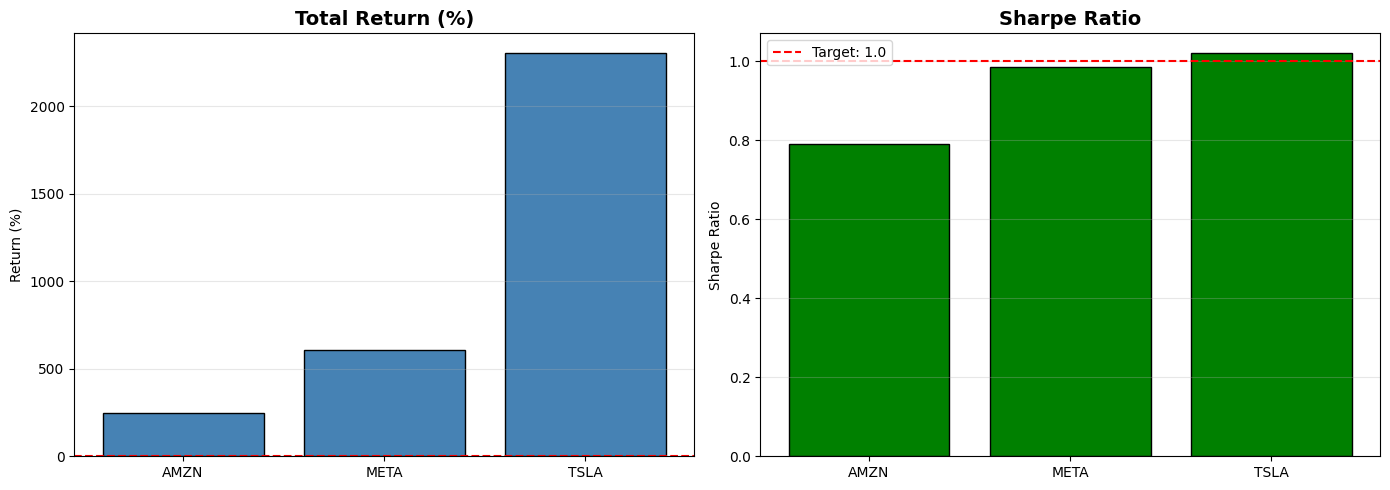


✓ Visualization complete!


In [13]:
import matplotlib.pyplot as plt

if len(results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Total returns
    tickers = [r['ticker'] for r in results]
    returns = [r['metrics']['total_return'] * 100 for r in results]

    axes[0].bar(tickers, returns, color='steelblue', edgecolor='black')
    axes[0].set_title('Total Return (%)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Return (%)')
    axes[0].axhline(y=0, color='red', linestyle='--')
    axes[0].grid(axis='y', alpha=0.3)

    # Sharpe ratios
    sharpes = [r['metrics']['sharpe_ratio'] for r in results]

    axes[1].bar(tickers, sharpes, color='green', edgecolor='black')
    axes[1].set_title('Sharpe Ratio', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Sharpe Ratio')
    axes[1].axhline(y=1.0, color='red', linestyle='--', label='Target: 1.0')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n✓ Visualization complete!")
else:
    print("No results to visualize")

## 10. Next Steps

After training, you can:

1. **Download models**: Models are saved locally and to Google Drive (if on Colab)
2. **Paper trading**: Use the trained models with Alpaca API for paper trading
3. **Hyperparameter tuning**: Adjust learning rate, episodes, chunk length, etc.
4. **Add more tickers**: Extend the ticker list in configuration
5. **Analyze ensemble weights**: Examine QP optimization results

**Important Notes:**
- Training time: ~20-30 minutes per ticker
- API usage: ~50-100 Gemini API calls per ticker (with caching and news skipping)
- Always validate on out-of-sample data before real trading
- Consider proper train/validation/test splits for production use

---

🤖 **Complete training pipeline for Google Colab**  
✨ **No Google Cloud deployment required**  
⚡ **Optimized with caching, rate limiting, and parallelization**